# Use DeepCCA to transform ADNI features

## Importing Stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import numpy as np
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler
from DeepCCAModels import DeepCCA
from main import Solver
from utils import load_data, svm_classify
from objectives import cca_loss
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pprint

## Read the database, examine it:

The data is located at "./DATA/Reduced_Linearly_Transformed_Unique_Dataset.pkl" 

We also need to read the OPNMF Loading Coefficients, and those are going to be our imaging data. 
The coefficients are located at "./DATA/loading_coefficients_30components.tsv". They are reduced to 
a dimension of 30 components.

In [30]:
unique = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
unique.reset_index(drop=True, inplace=True)
print(unique.shape)
unique.head(15)

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2
5,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-126.260419,...,0,0,0,0,1,0,0,0,2,1
6,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,200.102369,...,0,1,1,0,1,0,0,0,0,1
7,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-60.539913,...,2,1,1,0,1,0,0,0,1,2
8,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1058.028132,...,1,0,0,0,1,0,0,0,1,1
9,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-485.048304,...,1,1,1,0,0,0,0,0,0,1


In [31]:
opnmf_coeffs = pd.read_csv("./DATA/loading_coefficients_30components.tsv", sep='\t')
print(opnmf_coeffs.shape)
opnmf_coeffs.head(15)

(1294, 33)


,participant_id,session_id,path,component_1,component_2,component_3,component_4,component_5,component_6,component_7,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
0,002_S_0295,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,912.99866,842.33325,831.71893,1042.49220,1083.90710,670.48160,784.81110,...,839.09924,619.73230,681.45100,832.04670,659.40180,598.43787,737.67930,849.03940,653.38510,529.58984
1,002_S_0413,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,823.07510,780.51350,770.62060,901.71234,917.71313,618.90840,828.32007,...,765.77704,861.15450,674.06160,755.78380,719.56067,937.99410,694.54680,825.40790,766.40090,773.84576
2,002_S_0559,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,896.78010,931.24915,1173.90540,911.99170,908.41504,749.03250,988.38477,...,1046.81020,843.50710,877.13410,885.02180,911.55505,906.45730,701.53510,894.42840,837.21240,713.27203
3,002_S_0619,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,872.89777,1011.12885,952.32367,1081.24560,1135.83150,764.39440,823.27960,...,857.98660,813.39230,913.79160,875.58560,1001.27344,827.59820,686.68600,651.28410,764.98206,742.52910
4,002_S_0729,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,799.76800,702.03735,825.50490,819.52435,871.45575,642.43066,679.25323,...,600.88570,702.83550,673.74255,764.65850,650.25160,685.98645,587.51636,666.16100,624.62510,647.47455
5,002_S_0816,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,935.90173,904.85030,1068.48660,833.15295,869.03230,722.40670,900.58360,...,941.39685,749.70526,827.75200,856.35065,678.61640,729.16160,626.40590,774.68340,857.99414,617.07587
6,002_S_0938,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,763.87410,666.19420,751.04395,787.73254,902.59890,555.30945,702.55975,...,619.10270,741.98724,691.55440,546.40186,702.20953,802.19720,676.04670,507.42386,834.45514,660.77460
7,002_S_0954,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,799.99390,604.88116,1058.69450,753.52400,828.36145,563.47675,639.34045,...,598.07935,479.03888,507.04572,489.14060,491.81630,603.75930,520.15784,588.56950,572.01660,503.36550
8,002_S_0955,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,828.01070,809.28253,850.39040,821.97160,978.87480,612.34015,724.43760,...,843.48520,656.23420,706.19210,609.48890,808.98870,701.59686,659.30005,588.45310,586.52386,661.83734
9,002_S_1018,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,877.81720,746.37020,979.36390,1023.07086,1095.75070,606.95306,652.39770,...,862.20703,825.19970,696.64390,778.52200,674.44110,578.46576,703.68823,793.19147,721.19824,666.04390


In [32]:
opnmf_coeffs.describe()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000
mean,863.777507,781.904471,905.140011,909.370950,915.027364,669.806835,823.367620,706.792204,892.493370,732.315230,...,832.377176,785.466661,743.112438,751.624929,739.858197,744.528792,719.829262,774.191859,751.537933,686.830767
std,78.371161,82.182798,128.865778,111.816722,137.583178,76.249792,129.473465,110.927316,139.243792,106.202669,...,137.544145,119.337638,109.436300,119.358767,118.147490,120.946548,108.284309,120.942445,111.793852,99.958751
min,602.786130,599.079960,599.223450,568.550350,589.073400,399.038060,441.559050,385.688750,457.316200,404.042200,...,460.988160,353.536130,464.752350,413.940160,364.682860,453.444370,353.239440,400.764280,420.010400,388.626100
25%,810.117043,722.402055,816.202600,831.624082,821.333647,617.629613,732.665600,634.250387,791.039260,660.080187,...,735.486650,705.654567,669.527582,671.791912,657.370375,656.151563,646.184825,696.866845,672.129320,619.188275
50%,862.579650,778.983400,891.914365,906.916450,904.696870,664.257080,813.917550,703.791320,886.171125,720.097100,...,829.508780,780.940705,734.538470,749.446330,731.065555,737.287950,712.069420,779.084045,741.242580,677.992400
75%,913.483925,835.919130,986.971632,981.082065,998.064525,713.938953,903.165055,777.107850,985.469943,799.073865,...,919.835075,857.195625,808.003338,825.998950,811.361300,823.273120,788.066862,856.068262,821.149250,744.988095
max,1178.071200,1087.235100,1420.445700,1297.013800,1518.281000,1084.396600,1396.545000,1114.828100,1429.093100,1217.897600,...,1380.400300,1266.960700,1147.821000,1351.282800,1272.634200,1244.540300,1150.189600,1161.774700,1223.262200,1024.356800


In [33]:
print(unique.shape)
print(opnmf_coeffs.shape)
unique = unique[unique['PTID'].isin(opnmf_coeffs['participant_id'])]
print(unique.shape)
print(opnmf_coeffs.shape)

(1302, 209)
(1294, 33)
(1294, 209)
(1294, 33)


##  Building, training the DCCA Model

### Create the 2 views:

The first view consists of the imaging data, that are in the form of 30 real numbers. Those numbers are the outcome of Orthogonal Projection Non-Negative Matrix Factorization (OPNMF) on the RAVENS data.

The second view consists of the 54 SNP (Single Nucleotide Polymorphism, "snip"), for each individual. They are either 0 or 1. 

The 2 views are the most basic views that can be used for the Deep CCA, and in further tests more features will be included.

In [6]:
# View 1:
view_1 = opnmf_coeffs.loc[:,"component_1":"component_30"]

# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]

In [7]:
print("View 1:")
display(view_1.head())
print("View 2:")
display(view_2.head())

View 1:


,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
0,912.99866,842.33325,831.71893,1042.49220,1083.90710,670.48160,784.81110,784.83930,1107.9929,742.97406,...,839.09924,619.7323,681.45100,832.0467,659.40180,598.43787,737.67930,849.0394,653.38510,529.58984
1,823.07510,780.51350,770.62060,901.71234,917.71313,618.90840,828.32007,758.25574,722.0375,975.20610,...,765.77704,861.1545,674.06160,755.7838,719.56067,937.99410,694.54680,825.4079,766.40090,773.84576
2,896.78010,931.24915,1173.90540,911.99170,908.41504,749.03250,988.38477,787.45593,840.4178,765.08220,...,1046.81020,843.5071,877.13410,885.0218,911.55505,906.45730,701.53510,894.4284,837.21240,713.27203
3,872.89777,1011.12885,952.32367,1081.24560,1135.83150,764.39440,823.27960,975.41766,1100.7651,826.42750,...,857.98660,813.3923,913.79160,875.5856,1001.27344,827.59820,686.68600,651.2841,764.98206,742.52910
4,799.76800,702.03735,825.50490,819.52435,871.45575,642.43066,679.25323,712.70260,805.9348,589.86010,...,600.88570,702.8355,673.74255,764.6585,650.25160,685.98645,587.51636,666.1610,624.62510,647.47455


View 2:


,rs4575098,rs6656401,rs2093760,rs4844610,rs4663105,rs6733839,rs10933431,rs35349669,rs6448453,rs190982,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,0,0,0,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,1,0,0,0,0
2,0,0,0,0,1,0,1,0,0,1,...,2,0,0,0,0,1,0,0,0,0
3,0,1,1,1,0,0,0,2,1,1,...,1,0,0,0,1,1,0,0,0,2
4,0,0,0,0,1,1,0,1,0,0,...,1,0,0,0,1,1,0,0,0,1


### Parameters:

In [8]:
# if a gpu exists, torch.device should be 'gpu'
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
# print("Using", torch.cuda.device_count(), "GPUs")

# the size of the new space learned by the model (number of the new features)
outdim_size = 100

# size of the input for view 1 and view 2
input_shape1 = 30 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]

# number of layers with nodes in each one
# this apparently can be different for each network, some experimentation is needed!
layer_sizes1 = [256, 1024, 1024, outdim_size]
layer_sizes2 = [256, 1024, 1024, outdim_size]
# layer_sizes1 = [64, 128, outdim_size]
# layer_sizes2 = [64, 128, outdim_size]
# the parameters for training the network
learning_rate = 1e-4
epoch_num = 150
epoch_log_freq = 50
batch_size = 1000

# the path to save the final learned features, as DCCA-o-d.
save_to = './DATA/ADNI_OPNMF_DCCA_features_'+str(outdim_size)+'_'+str(len(layer_sizes1)-1)+'.pkl'

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-3

# specifies if all the singular values should get used to calculate the correlation or just the top 
# outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False

# if a linear CCA should get applied on the learned features extracted from the networks
# it does not affect the performance on noisy MNIST significantly
apply_linear_cca = True

### Training the DCCA model:

In [9]:
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()

In [10]:
# View 1:
view_1 = opnmf_coeffs.loc[:,"component_1":"component_30"]
# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

(1294, 30) <class 'numpy.ndarray'> float64
(1294, 54) <class 'numpy.ndarray'> float64
torch.Size([1294, 30]) <class 'torch.Tensor'>
torch.Size([1294, 54]) <class 'torch.Tensor'>


In [11]:
data1 = view_1_t
data2 = view_2_t

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                input_shape2, outdim_size, use_all_singular_values, device=device).double()
l_cca = None
if apply_linear_cca:
    l_cca = linear_cca()
    
    
solver = Solver(model, l_cca, outdim_size, epoch_num, batch_size,
                learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=True)
s_1, s_2 = data1.shape[0], data2.shape[0]

# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()
# TODO: Save linear_cca model if needed

[ INFO : 2022-03-15 19:04:42,603 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=30, out_features=256, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (1): Linear(in_features=1024, out_features=100, bias=True)
       

In [12]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

[-88.73  -47.925]


In [13]:
print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

<class 'numpy.ndarray'>
(1294, 100)
<class 'numpy.ndarray'>
(1294, 100)


### Plotting the Losses:

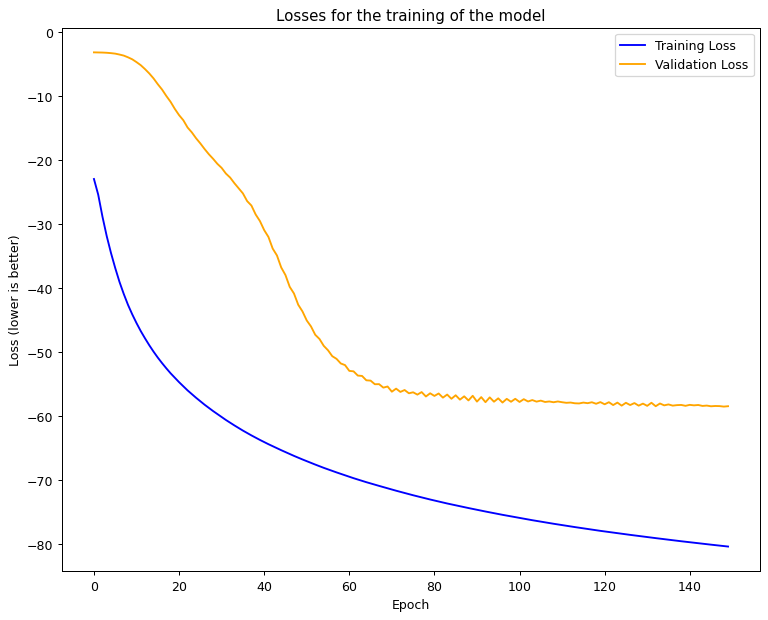

In [17]:
x = np.arange(len(training_losses))
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

## Producing the best new features by DCCA

### Using GridSearch Cross with Validation to find the best parameters:

In [6]:
# View 1:
normalized_opnmf_coeffs=(opnmf_coeffs.loc[:,"component_1":"component_30"]-
                         opnmf_coeffs.loc[:,"component_1":"component_30"].min())/(opnmf_coeffs.loc[:,"component_1":"component_30"].max()-
                                                                                  opnmf_coeffs.loc[:,"component_1":"component_30"].min())
view_1 = normalized_opnmf_coeffs.loc[:,"component_1":"component_30"]
# View 2:
view_2 = unique.loc[:,"rs4575098":"rs429358"]
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy().astype(np.float64)
# # Scramble the datapoints for randomness:
# indices = np.arange(view_1_n.shape[0])
# # np.random.shuffle(indices)
# view_1_n = view_1_n[indices]
# view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

# Standard parameters that shouldn't be changed:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
input_shape1 = 30 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 100

(1294, 30) <class 'numpy.ndarray'> float64
(1294, 54) <class 'numpy.ndarray'> float64
torch.Size([1294, 30]) <class 'torch.Tensor'>
torch.Size([1294, 54]) <class 'torch.Tensor'>


In [7]:
# Parameters that should be explored, example values:
outdim_sizes = [10,50,100,150]
hidden_layer_sizes = [[256,256,256],
                      [1024,1024,1024],
                      [256,256,256,256],
                      [1024,1024,1024,1024]]
learning_rates = [1e-2,1e-3,1e-4]
batch_sizes = [500,1000]
reg_pars = [1e-2,1e-3,1e-4]

results = []
best_test_loss = (1000,None)
count=0

for outdim_size in outdim_sizes:
    for hidden_layer_size in hidden_layer_sizes:
        hidden_layer_size1 = hidden_layer_size
        hidden_layer_size2 = hidden_layer_size
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for reg_par in reg_pars:
                    count += 1
                    parameters = {"outdim": outdim_size,
                                  "hidden_layer_size1": hidden_layer_size1,
                                  "hidden_layer_size2": hidden_layer_size2,
                                  "learning_rate": learning_rate,
                                  "batch_sz": batch_size,
                                  "reg_par": reg_par}
                    print("Variation ", count, ":", parameters)
                    layer_sizes1 = hidden_layer_size1 + [outdim_size]
                    layer_sizes2 = hidden_layer_size2 + [outdim_size]

                    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, 
                                    use_all_singular_values, device=device).double()

                    solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size,
                                    learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)
                    s_1, s_2 = data1.shape[0], data2.shape[0]

                    # Split the dataset into training, validation and testing (75%-15%-10%):
                    train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
                    val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
                    test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

                    test_loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
                    print(test_loss)
                    if test_loss < best_test_loss[0]:
                        best_test_loss = (test_loss, parameters)
                    training_losses, val_losses = solver.get_losses()
                    results.append((training_losses, val_losses, test_loss, parameters))

print("With a loss of " + str(best_test_loss[0]) + ", the configuration with the best Test loss was:")
pprint.pprint(best_test_loss[1])

Variation  1 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.01}
-2.4707037092424953
Variation  2 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.001}
-2.537820699097604
Variation  3 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.0001}
-2.3931262673267604
Variation  4 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 1000, 'reg_par': 0.01}
-2.440311402328304
Variation  5 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 1000, 'reg_par': 0.001}
-2.324578657897362
Variation  6 : {'outdim': 10, 'hidden_layer_size1': [256, 256, 256], 'hi

In [ ]:
with open("OPNMFGridSearch_Results.pkl", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

### Using the model with the best parameters:

In [ ]:
with open("OPNMFGridSearch_Results.pkl", "rb") as fp:   # Unpickling
    results = pickle.load(fp)

print("The nunmber of different results are: ", len(results))
print()
# each result is in the format ([training_losses], [validation_losses], test_loss, parameters):
from operator import itemgetter

best_test_loss = min(results, key=itemgetter(2))
print("The best test loss that was managed is: ", best_test_loss[2])
print("The test loss was managed with the following parameters:")
pprint.pprint(best_test_loss[3])
print()

x = np.arange(len(best_test_loss[0])) # number of epochs in training, also in validation
plt.figure(figsize=(10, 8), dpi=90)
training_losses = best_test_loss[0]
val_losses = best_test_loss[1]
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.plot(x, [best_test_loss[2]]*len(best_test_loss[0]), marker='.', color='red', label="Test Loss Achieved")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

In [10]:
# Standard parameters that shouldn't be changed:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')
input_shape1 = 30 # view_1.shape[1]
input_shape2 = 54  # view_2.shape[2]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 300

parameters=best_test_loss[3]

batch_size=parameters['batch_sz']
hidden_layer_size1 = parameters['hidden_layer_size1']
hidden_layer_size2 = parameters['hidden_layer_size2']
learning_rate = parameters['learning_rate']
outdim_size = parameters['outdim']
reg_par = parameters['reg_par']
layer_sizes1 = hidden_layer_size1 + [outdim_size]
layer_sizes2 = hidden_layer_size2 + [outdim_size]

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, use_all_singular_values, device=device).double()
solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size, learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=True)

s_1, s_2 = data1.shape[0], data2.shape[0]
# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()

# TODO: Save linear_cca model if needed

[ INFO : 2022-03-15 23:02:00,223 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=30, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, trac

In [14]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

print()

print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

[-145.388  -96.4  ]

<class 'numpy.ndarray'>
(1294, 150)
<class 'numpy.ndarray'>
(1294, 150)


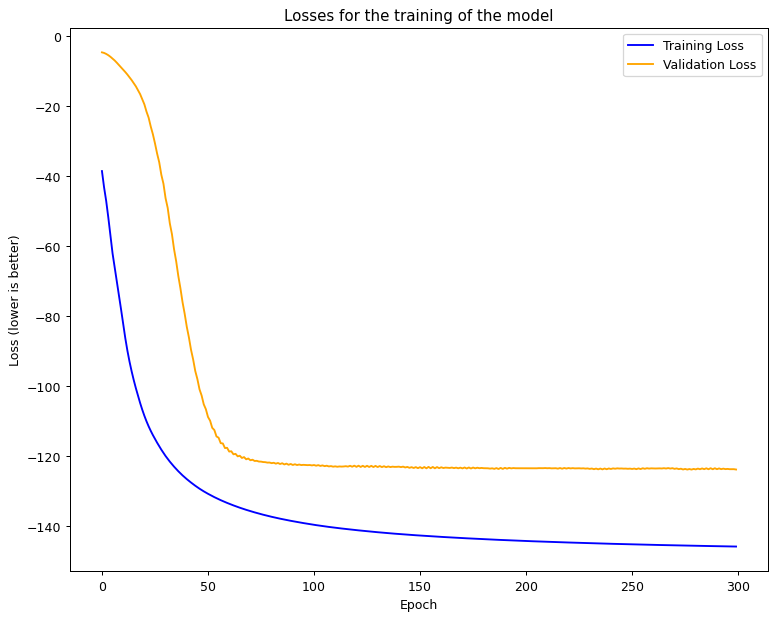

In [15]:
x = np.arange(epoch_num)
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

## Testing the Model:

### Testing the Correlation between inputs and outputs of the deep Network:

In [16]:
from sklearn.cross_decomposition import CCA

print("CCA on input data:")
X = data1
Y = data2
cca = CCA(n_components=30)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
print(cca.score(X, Y))

print("CCA on output data:")
X = outputs[0]
Y = outputs[1]
cca = CCA(n_components=30,max_iter=10000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
# The best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse)
print(cca.score(X, Y)) 

CCA on input data:
-1.225506029776847
CCA on output data:
0.13911466589467103


### (Imaging) Training and testing of SVM with linear kernel on the view 1 with new features vs old features: 

In [17]:
s = svm.LinearSVC(dual=False)
X , Y = view_1, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = outputs[0], unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 0.1}
Untrained Accuracy:  54.63
Best Parameters for trained data: {'C': 0.001}
Trained Accuracy:    49.924


### (Genetic) Training and testing of SVM with linear kernel on the view 2 with new features vs old features: 

In [18]:
s = svm.LinearSVC(dual=False)
X , Y = view_2, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = outputs[1], unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 0.0001}
Untrained Accuracy:  48.068
Best Parameters for trained data: {'C': 0.001}
Trained Accuracy:    49.685


### (Imaging + Genetic) Training and testing of SVM with linear kernel on both views with new features vs old features: 

In [19]:
print(outputs[0].shape)
print(outputs[1].shape)
both = np.concatenate((outputs[0], outputs[1]), axis=1)
print(both.shape)

(1294, 150)
(1294, 150)
(1294, 300)


In [51]:
unique.reset_index(drop=True, inplace=True)
normalized_opnmf_coeffs.reset_index(drop=True, inplace=True)

print(unique.loc[:,"rs4575098":"rs429358"].shape)
print(normalized_opnmf_coeffs.shape)
combined = pd.concat([unique.loc[:,"rs4575098":"rs429358"], normalized_opnmf_coeffs], axis=1, ignore_index=True, join='outer')
print(combined.shape)
combined.head()

(1294, 54)
(1294, 30)
(1294, 84)


,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0,0,0,0,1,1,1,0,0,1,...,0.411253,0.291427,0.317243,0.446055,0.324598,0.183282,0.482389,0.589053,0.290537,0.221735
1,1,0,0,0,0,0,0,1,0,0,...,0.331504,0.555731,0.306425,0.364694,0.390856,0.612504,0.428267,0.558000,0.431235,0.605948
2,0,0,0,0,1,0,1,0,0,1,...,0.637170,0.536411,0.603719,0.502571,0.602314,0.572640,0.437036,0.648696,0.519391,0.510666
3,0,1,1,1,0,0,0,2,1,1,...,0.431796,0.503442,0.657385,0.492504,0.701129,0.472956,0.418403,0.329194,0.429469,0.556687
4,0,0,0,0,1,1,0,1,0,0,...,0.152160,0.382406,0.305958,0.374162,0.314520,0.293949,0.293967,0.348743,0.254733,0.407167


In [53]:
s = svm.LinearSVC(dual=False)
X , Y = combined , unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for untrained data:",clf.best_params_)
acc_untrained = clf.best_score_
print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))

s = svm.LinearSVC(dual=False)
X , Y = both, unique["Diagnosis_nearest_2.0_cat"]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
clf = GridSearchCV(s, parameters, n_jobs=-1, cv=10)
clf.fit(X,Y)
print("Best Parameters for trained data:",clf.best_params_)
acc_trained = clf.best_score_
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

Best Parameters for untrained data: {'C': 10}
Untrained Accuracy:  53.398
Best Parameters for trained data: {'C': 0.01}
Trained Accuracy:    51.701
